In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np

In [87]:
df = pd.read_csv('https://raw.githubusercontent.com/plenoi/Clinic/master/ultima_all_clean.csv')
df = df.set_index('hn')

df_clean_column = df.drop(['appearance','Wardsize','RHlvsi','depth','nodeyiel','vgmargin','pelvicme','adnmet'],axis = 1)
df_clean_column.isnull().sum(axis=0)
df_clean = df_clean_column.dropna(axis = 0)
df['pmmet'].unique()

df.head()


,age,parity,hiv,menopaus,disease,surgery,conization,OPDsize,appearance,stage,...,nodeyiel,RHlvsi,depth,size,utmet,vgmargin,vgmet,pelvicme,pmmet,adnmet
hn,,,,,,,,,,,,,,,,,,,,,
2631840,52,3,0.0,0.0,1,1,0.0,5.0,4.0,5.0,...,21.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
2633481,32,2,0.0,0.0,0,1,0.0,5.0,1.0,5.0,...,11.0,0.0,3.0,5.0,0.0,0.0,0.0,1.0,0.0,2.0
2634477,52,2,0.0,0.0,0,0,0.0,5.0,NaN,5.0,...,35.0,6.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
2633633,38,2,0.0,0.0,0,0,0.0,2.0,1.0,4.0,...,20.0,16.0,3.0,3.8,0.0,0.0,0.0,0.0,0.0,2.0
2630496,55,3,0.0,1.0,0,0,1.0,0.0,5.0,4.0,...,17.0,9.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [107]:
y = df_clean['pmmet'].values
X = df_clean.drop(['pmmet'],axis = 1).values

In [108]:
from imblearn.over_sampling import SMOTE   ## split ตัว test ออกมาก่อน
sm = SMOTE(random_state=1)
X, y =sm.fit_resample(X,y)

In [114]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectFdr, chi2
X, y = load_breast_cancer(return_X_y=True)
X.shape
(569, 30)
X_new = SelectFdr(chi2, alpha=0.01).fit_transform(X, y)
X_new.shape
(569, 16)

(569, 16)

In [115]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)   ## 

In [116]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

# Support Vector Machine

In [117]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
params = {
    'C' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1], # High C = Overfitting
    'gamma' : [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32] # High gamma = Overfitting
}
clf = GridSearchCV(SVC(random_state=0),params, cv=10)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'C': 1, 'gamma': 1}
10CV accuracy : 98.03381642512076


In [118]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)*100

97.36842105263158

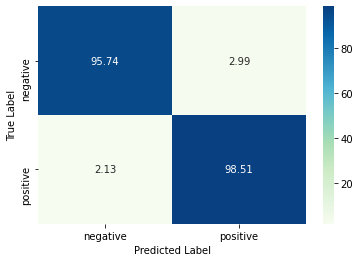

In [119]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Random Forest

In [120]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
params = {
    'n_estimators' : [10,50,100],
    'min_samples_leaf' : [0.25,0.5,1],
    'max_features': ['auto', 'sqrt'],
    'criterion' : ['gini','entropy']
}
clf = GridSearchCV(RandomForestClassifier(random_state=0),params, cv = 5)
clf.fit(X_train_norm, y_train)
print("Best params : " + str(clf.best_params_))
print("10CV accuracy : "+str(clf.best_score_*100))

Best params : {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}
10CV accuracy : 96.48351648351647


In [121]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_predict = clf.predict(X_test_norm)
target_names = ['negative', 'positive']
sum(y_test == y_predict)/len(y_test)*100

97.36842105263158

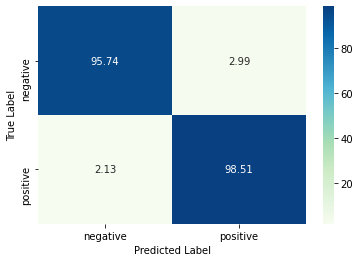

In [122]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
target_names = ['negative', 'positive']
C = confusion_matrix(y_test,y_predict) 
C = C / C.astype(np.float).sum(axis=1)*100
sns.heatmap(C, annot=True, fmt=".2f",cmap="GnBu",xticklabels=target_names, yticklabels=target_names)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()